# Predictive distribution models

In this notebook we explore two different approaches we could use to generate predictive distributions for rewards.
These methods are

1. **Bootstrapped oracles**. We produce $n_{boot}$ bootstrap samples of the input dataset referring to a specific action (i.e. the rows where that specific action has been played). For each sample we train a classifier and then use the collection of trained models (bootstrapped oracles) to produce a predictive distribution of the probability of success for each context (see https://arxiv.org/pdf/1811.04383.pdf) for more details.

<img src="./images/bootstrap_oracle.png" width="900">

2. **Bayesian logistic model**. We build a Bayesian logistic regression model that would allow us to draw sample of probabilities from a model predictive distribution. How does it work? 

    We want to fit the following generalized linear model

    \begin{align}
    y &\sim \text{Bern}(𝑝(X))\\
    p(X) &= \frac{1}{1+e^{-{\bf \beta}^T X +\epsilon}}\\
    \epsilon &\sim \mathcal(0,\sigma) 
    \end{align}
    
    Fitting the model implies determining the set of model coefficients ${\hat \beta} = ({\hat \beta_0},{\hat \beta_1},...,{\hat \beta_p})$ via a minimization process. In the Bayesian setting we assume a prior knowledge on the values of these model coefficients, usually expressed via a multivariate normal distribution with some initial parameters
    
    \begin{equation}
    \beta \sim \mathcal{N}({\bf 0},\Sigma)
    \end{equation}
    
    Given the distribution on the model parameters, we can compute the probability distribution of the response $y$ given the predictor $X$ by sampling values of $\beta$:
    
    \begin{equation}
    p(y|X) = \int d\beta \frac{p(y,X)|\beta)p(\beta)}{p(X)}
    \end{equation}
    
    Let us now suppose we have a set of observations $(X^*, Y^*)$, and a prior on the model vector $\beta$. How can we update our prior assumption so that the samples we produce will be as much close as possible to the data we observe? The answer is via Bayes' theorem
    
    \begin{equation}
    p(\beta|y^*,X^*|) \propto p(y^*,X^*|\beta)p(\beta)
    \end{equation}
    
    Via Bayes' theorem we can compute what is the probability distribution of the model coefficients **given** the observed data (predictor and response): this **posterior distribution** represent the update of our prior assumption.
    Provided we can efficiently compute the posterior distribution for the moel coefficients, then we can use it to sample probability distribution for each context $x$ of the predictor matrix $X$.
    
The notebook has the following structure

1. [Modules loading](#Modules-loading)
2. [Synthetic data generation](#Synthetic-data-generation)
3. [Oracle models](#Oracle-models)
    * [Logistic Regression](#Logistic-Regression)
    * [Linear SVM classifier](#Linear-SVM-classifier)
    * [Gradient boosting classifier](#Gradient-boosting-classifier)
    * [Oracles assessment](#Oracles-assessment)
4. [Bayesian logistic model](#Bayesian-logistic-model)
    * [Posterior distributions for model vector](#Posterior-distributions-for-model-vector)
    * [Comparison with bootstrap oracle](#Comparison-with-bootstrap-oracle)
    * [Model assessment](#Model-assessment)

## Modules loading

In [1]:
import os
import sys
sys.path.append('/Users/fci02/Documents/GitHub/decisioning-analysis/test_and_learn/production_modules/')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Synthetic data generation

In [2]:
from contextual_mab.data_utils.data_generation  import generate_synthetic_data

In [3]:
n = 10000
nc = 3
cw = [.05,.03,.01]

ct_prm = {'X1':{'loc':0.,'scale':1.},
          'X2':{'loc':10.,'scale':5.},
          'X3':{'loc':-.3,'scale':.5}}

ord_prm = {'O1':{'start':1,'stop':11,'weights':[.1]*10},
           'O2':{'start':1,'stop':4,'weights':[.3,.4,.3]}}

catg_prm = {'C1':{'levels':['Yes','No'],'weights':[.4,.6]},
            'C2':{'levels':['Green','Yellow'],'weights':[.2,.8]},
            'C3':{'levels':['A','B','C'],'weights':[.4,.1,.5]}}
seed = 0
noise_scale=5.

In [4]:
synthetic_data = generate_synthetic_data(n,nc,cw,
                       ct_prm,ord_prm,catg_prm,seed,noise_scale,
                       return_inputs=False,output_info=True)

Total number of data: 30000
Actions played: [1, 2, 3]
Global expected rewards per action


,reward
action_code,
1,0.05
2,0.03
3,0.01


In [5]:
synthetic_data.head()

,X1,X2,X3,O1,O2,C1,C2,C3,reward,action_code
0,1.764052,11.856161,-0.838830,8,1,Yes,Green,C,0,1
1,0.400157,11.523919,-0.721146,6,2,No,Green,A,0,1
2,0.978738,12.520623,-0.428904,1,3,Yes,Yellow,C,0,1
3,2.240893,10.676498,0.056038,5,2,Yes,Yellow,C,0,1
4,1.867558,13.268794,-0.027104,7,3,No,Yellow,C,0,1


## Oracle models 

We train three different classifiers just on a subset of the data, the one where action $1$ has been played

In [6]:
from contextual_mab.predictive_models.oracles import BootstrapOracle

n_bootstrap = 100
action_id=1
subset = synthetic_data[synthetic_data['action_code']==action_id]
X = pd.get_dummies(subset.drop(columns=['reward','action_code']),drop_first=True).values
y = subset['reward'].values

### Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression

logistic_params = {'solver':'lbfgs',
                   'random_state':0}

logistic_oracle = BootstrapOracle(n_bootstrap,LogisticRegression,logistic_params)

logistic_oracle.fit(X,y)
logistic_oracle_predictions = logistic_oracle.predict(X)

100%|██████████| 100/100 [00:04<00:00, 23.23it/s]
100it [00:00, 2107.62it/s]


### Linear SVM classifier

In [8]:
from sklearn.svm import SVC

svc_params = {'C':1.0,
              'kernel':'linear',
              'probability':True,
              'random_state':0}

svc_oracle = BootstrapOracle(n_bootstrap,SVC,svc_params)

svc_oracle.fit(X,y)
svc_oracle_predictions = svc_oracle.predict(X)

100%|██████████| 100/100 [03:25<00:00,  1.93s/it]
100it [00:09,  7.45it/s]


### Gradient boosting classifier

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

gb_params = {'n_estimators':100,
             'learning_rate':.1,
             'random_state':0}

gb_oracle = BootstrapOracle(n_bootstrap,GradientBoostingClassifier,gb_params)

gb_oracle.fit(X,y)
gb_oracle_predictions = gb_oracle.predict(X)

100%|██████████| 100/100 [00:52<00:00,  1.99it/s]
100it [00:01, 87.07it/s]


We can plot the predictive distributions for three different contexts

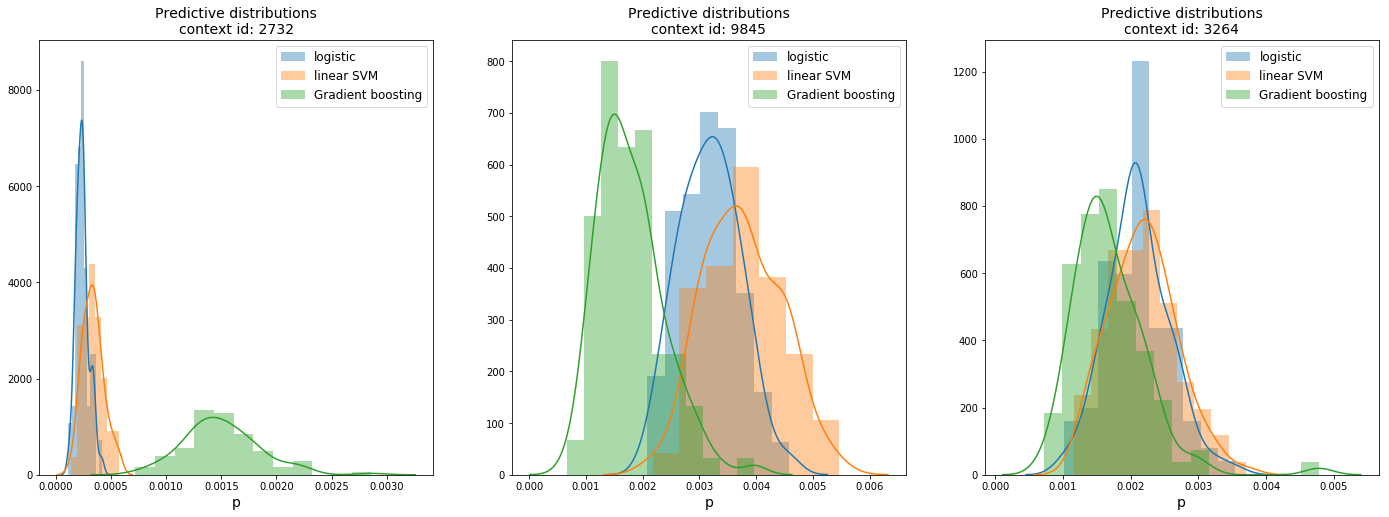

In [10]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,8))

np.random.seed(0)
context_idx = np.random.choice(range(X.shape[0]),3)
for idx,ax in zip(context_idx,[ax1,ax2,ax3]):
    sns.distplot(logistic_oracle_predictions[idx,:],label='logistic',ax=ax)
    sns.distplot(svc_oracle_predictions[idx,:],label='linear SVM', ax=ax)
    sns.distplot(gb_oracle_predictions[idx,:],label='Gradient boosting',ax=ax)
    ax.legend(fontsize=12)
    ax.set_title('Predictive distributions\ncontext id: {}'.format(idx),fontsize=14)
    ax.set_xlabel('p',fontsize=14)
plt.show()

No calibration of predictive scores has been done, this explains the difference in predictions between the Gradient Boosting classifier and the other two simpler learning algorithms.

### Oracles assessment

To understand whether or not we can confidently apply Thompson Sampling using the oracles' predictions, we need to inspect the predictive distributions for a small sample of contexts. For this specific model assessment we will use a logistic regression classifier as it can be trained quite rapidly.

How can we assess the quality of the oracles? 

We start by generating a synthetic datasets with just ordinal and categorical features, so that we can keep the number of available contexts small. 
Then for each context $C_i$ we can compute the number of successess and failures experienced by the play of each action

| Context | action  $i$||
|------|------|------|
|------| successes  | failures |
|   $C_1$  | $S_1$|$F_1$|
|   $C_2$  | $S_2$|$F_2$|
|   ...  | ...|...|
|   $C_n$  | $S_n$|$F_n$|

These values can be used to understand where the observed reward of each context is located via plotting a beta distribution with the parameters given in each row.

<img src="./images/context_beta.png" width="500">

At the same time we can look at the probability distributions produced by the oracles for each context

| Context | action  $i$|
|---------|------------|
|---------| probabilities |
|   $C_1$  | [$p_{11}$,$p_{12}$,...,$p_{1n_b}$]  |
|   $C_2$  |  [$p_{21}$,$p_{22}$,...,$p_{2n_b}$]  |
|   ...  | ...|
|   $C_n$  | [$p_{n1}$,$p_{n2}$,...,$p_{nn_b}$]  |

<img src="./images/context_oracle.png" width="500">

If the model can capture enough variability of the reward, then the oracles' predictive distributions should respect the same hierarchy order (from lowest to highest) as the one provided by the beta distributions. We **do not expect** the two distributions (oracle vs beta) to overlap, because the logistic models is calibrated on the **overall average reward** of a given action, no the one specific to each context.

In [11]:
n = 10000
nc = 3
cw = [.05,.03,.01]

ct_prm = {}

ord_prm = {'O1':{'start':1,'stop':5,'weights':[.25]*4},
           'O2':{'start':1,'stop':4,'weights':[.3,.4,.3]}}

catg_prm = {'C1':{'levels':['Yes','No'],'weights':[.4,.6]},
            'C2':{'levels':['Green','Yellow'],'weights':[.2,.8]}}
seed = 0
noise_scale=5

In [12]:
check_data = generate_synthetic_data(n,nc,cw,
                       ct_prm,ord_prm,catg_prm,seed,noise_scale,
                       return_inputs=False)

In [13]:
n_bootstrap = 100

logistic_params = {'solver':'lbfgs',
                   'random_state':0}

action_probabilities = []
predictors = check_data.drop(columns=['reward','action_code']).columns
for action_id in pd.unique(check_data['action_code']):
    subset = check_data[check_data['action_code']==action_id]
    X = pd.get_dummies(subset[predictors],drop_first=True).values
    y = subset['reward'].values
    
    logistic_oracle = BootstrapOracle(n_bootstrap,LogisticRegression,logistic_params)

    logistic_oracle.fit(X,y)
    
    unique_contexts = subset.drop_duplicates(subset=predictors)[predictors]
    X_unique = pd.get_dummies(unique_contexts,drop_first=True).values
    logistic_oracle_predictions = logistic_oracle.predict(X_unique)
    unique_contexts['action_code'] = action_id
    unique_contexts['bootstrap_probs_action'.format(action_id)] = [logistic_oracle_predictions[idx,:] for idx in range(len(logistic_oracle_predictions))]
    action_probabilities.append(unique_contexts)
    
action_probabilities=pd.concat(action_probabilities)
action_probabilities = action_probabilities.set_index(keys=predictors.tolist()+['action_code'])
action_probabilities = action_probabilities.unstack('action_code')

100%|██████████| 100/100 [00:01<00:00, 63.78it/s]
100it [00:00, 6923.24it/s]
100%|██████████| 100/100 [00:01<00:00, 60.99it/s]
100it [00:00, 12655.17it/s]
100%|██████████| 100/100 [00:01<00:00, 57.70it/s]
100it [00:00, 11437.97it/s]


In [14]:
action_probabilities.head()

bootstrap_probs_action  \
action_code                                                       1   
O1 O2 C1  C2                                                          
1  1  No  Green   [0.038512985258324146, 0.038888894744319925, 0...   
          Yellow  [0.03508105875670412, 0.038165484612089885, 0....   
      Yes Green   [0.058838631479139196, 0.050628612438420706, 0...   
          Yellow  [0.05369662147871923, 0.04969811271992621, 0.0...   
   2  No  Green   [0.041447251048379985, 0.04087088877044395, 0....   

                                                                     \
action_code                                                       2   
O1 O2 C1  C2                                                          
1  1  No  Green   [0.02623105291703449, 0.02940005387570486, 0.0...   
          Yellow  [0.028316676359966104, 0.03836522294750019, 0....   
      Yes Green   [0.020067861362467375, 0.016322239119280248, 0...   
          Yellow  [0.021674358497339074, 0.021387370900053923, 0...   
   2  No  Green   [0.03261064660478665, 0.03632618681661916, 0.0...   

                                                                     
action_code                                                       3  
O1 O2 C1  C2                                                         
1  1  No  Green   [0.009889467190182868, 0.007279119526462905, 0...  
          Yellow  [0.010127056897005788, 0.01016273694272416, 0....  
      Yes Green   [0.024035266818880796, 0.012467742991602101, 0...  
          Yellow  [0.024604257400203916, 0.017370862391679696, 0...  
   2  No  Green   [0.005566060201397623, 0.005452006794153619, 0...

In [15]:
subset = check_data
predictors = subset.drop(columns = ['reward']).columns.tolist()
grouped = subset.groupby(by=predictors)[['reward']].sum()
grouped['successes'] = grouped['reward']
grouped['failures'] = len(subset)-grouped['successes']
grouped.drop(columns='reward',inplace=True)
grouped=grouped.unstack('action_code')
grouped.head()

successes        failures              
action_code              1   2  3        1      2      3
O1 O2 C1  C2                                            
1  1  No  Green          3   2  1    29997  29998  29999
          Yellow        17  10  5    29983  29990  29995
      Yes Green          5   1  0    29995  29999  30000
          Yellow        14   6  4    29986  29994  29996
   2  No  Green          2   6  1    29998  29994  29999

In [16]:
comparison_frame = pd.merge(grouped,action_probabilities,left_index=True,right_index=True)
comparison_frame.head()

successes        failures                \
action_code              1   2  3        1      2      3   
O1 O2 C1  C2                                               
1  1  No  Green          3   2  1    29997  29998  29999   
          Yellow        17  10  5    29983  29990  29995   
      Yes Green          5   1  0    29995  29999  30000   
          Yellow        14   6  4    29986  29994  29996   
   2  No  Green          2   6  1    29998  29994  29999   

                                             bootstrap_probs_action  \
action_code                                                       1   
O1 O2 C1  C2                                                          
1  1  No  Green   [0.038512985258324146, 0.038888894744319925, 0...   
          Yellow  [0.03508105875670412, 0.038165484612089885, 0....   
      Yes Green   [0.058838631479139196, 0.050628612438420706, 0...   
          Yellow  [0.05369662147871923, 0.04969811271992621, 0.0...   
   2  No  Green   [0.041447251048379985, 0.04087088877044395, 0....   

                                                                     \
action_code                                                       2   
O1 O2 C1  C2                                                          
1  1  No  Green   [0.02623105291703449, 0.02940005387570486, 0.0...   
          Yellow  [0.028316676359966104, 0.03836522294750019, 0....   
      Yes Green   [0.020067861362467375, 0.016322239119280248, 0...   
          Yellow  [0.021674358497339074, 0.021387370900053923, 0...   
   2  No  Green   [0.03261064660478665, 0.03632618681661916, 0.0...   

                                                                     
action_code                                                       3  
O1 O2 C1  C2                                                         
1  1  No  Green   [0.009889467190182868, 0.007279119526462905, 0...  
          Yellow  [0.010127056897005788, 0.01016273694272416, 0....  
      Yes Green   [0.024035266818880796, 0.012467742991602101, 0...  
          Yellow  [0.024604257400203916, 0.017370862391679696, 0...  
   2  No  Green   [0.005566060201397623, 0.005452006794153619, 0...

In [17]:
from scipy.stats import beta

def plot_contexts_probabilities(comparison_frame,seeds):

    for seed in seeds:
        np.random.seed(seed)
        sub_sample = comparison_frame.sample(3)
        display(sub_sample)

        fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(30,10))
        for idx,axup,axdown in zip(sub_sample.index,(ax1,ax2,ax3),(ax4,ax5,ax6)):
             alphas = sub_sample.loc[idx,'successes'].values
             betas = sub_sample.loc[idx,'failures'].values
             probs = sub_sample.loc[idx,'bootstrap_probs_action'].values

             expected_means = alphas/(alphas+betas)
             for idx, (probo,mean,a,b) in enumerate(zip(probs,expected_means,alphas,betas)):
                 sns.distplot(probo,ax=axup,label='action {0:d}\n$\mu=${1:.3f}'.format(idx+1,probo.mean()))
                 points = np.linspace(beta.ppf(0.01, a, b),beta.ppf(0.99, a, b), 100)
                 axdown.plot(points,beta.pdf(points,a,b))
                 axdown.fill_between(points,0,beta.pdf(points,a,b),alpha=.5,label='action {0:d}\n$\mu=${1:}'.format(idx+1,mean))
             axup.legend()
             axdown.legend()
        plt.tight_layout()
        plt.show()

successes        failures                \
action_code              1   2  3        1      2      3   
O1 O2 C1  C2                                               
3  2  No  Yellow        25  20  3    29975  29980  29997   
1  2  No  Green          2   6  1    29998  29994  29999   
3  1  Yes Green          6   1  3    29994  29999  29997   

                                             bootstrap_probs_action  \
action_code                                                       1   
O1 O2 C1  C2                                                          
3  2  No  Yellow  [0.045503173510816716, 0.046537330655645484, 0...   
1  2  No  Green   [0.041447251048379985, 0.04087088877044395, 0....   
3  1  Yes Green   [0.0705797300752988, 0.058635425918496346, 0.0...   

                                                                     \
action_code                                                       2   
O1 O2 C1  C2                                                          
3  2  No  Yellow  [0.0307757915958999, 0.03701386991282409, 0.03...   
1  2  No  Green   [0.03261064660478665, 0.03632618681661916, 0.0...   
3  1  Yes Green   [0.01751856745333704, 0.012682899412592274, 0....   

                                                                     
action_code                                                       3  
O1 O2 C1  C2                                                         
3  2  No  Yellow  [0.005128746645089392, 0.008696823811007845, 0...  
1  2  No  Green   [0.005566060201397623, 0.005452006794153619, 0...  
3  1  Yes Green   [0.021665075163026782, 0.014224690539761164, 0...

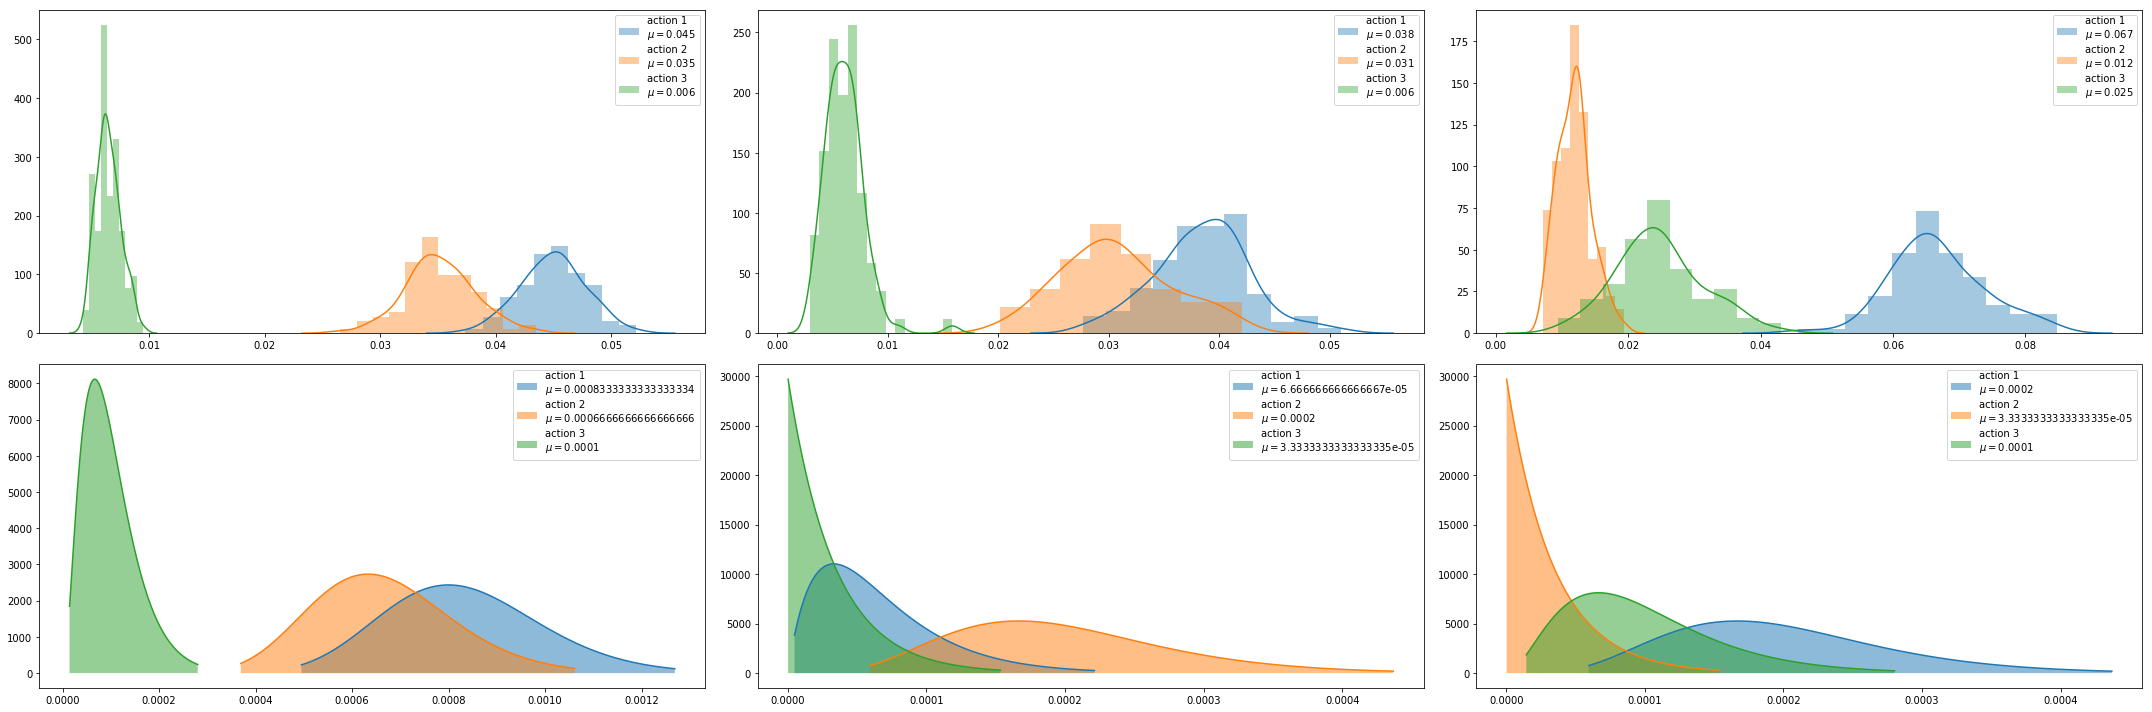

successes       failures                \
action_code              1  2  3        1      2      3   
O1 O2 C1  C2                                              
3  3  Yes Yellow        14  7  2    29986  29993  29998   
2  3  Yes Yellow        11  9  2    29989  29991  29998   
4  2  Yes Green          4  0  1    29996  30000  29999   

                                             bootstrap_probs_action  \
action_code                                                       1   
O1 O2 C1  C2                                                          
3  3  Yes Yellow  [0.0743474162420935, 0.06344863204007514, 0.05...   
2  3  Yes Yellow  [0.06792563904519831, 0.05898812488298329, 0.0...   
4  2  Yes Green   [0.0828616107947676, 0.06620061084024428, 0.07...   

                                                                     \
action_code                                                       2   
O1 O2 C1  C2                                                          
3  3  Yes Yellow  [0.029322666443444664, 0.025533610966221525, 0...   
2  3  Yes Yellow  [0.03135862514502876, 0.02891900359601823, 0.0...   
4  2  Yes Green   [0.02039658255144339, 0.013870598174218322, 0....   

                                                                     
action_code                                                       3  
O1 O2 C1  C2                                                         
3  3  Yes Yellow  [0.007072456404761809, 0.011167112261571629, 0...  
2  3  Yes Yellow  [0.007455449288715398, 0.010452982992402304, 0...  
4  2  Yes Green   [0.011630638951610154, 0.01140191436458268, 0....

/Users/fci02/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/fci02/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


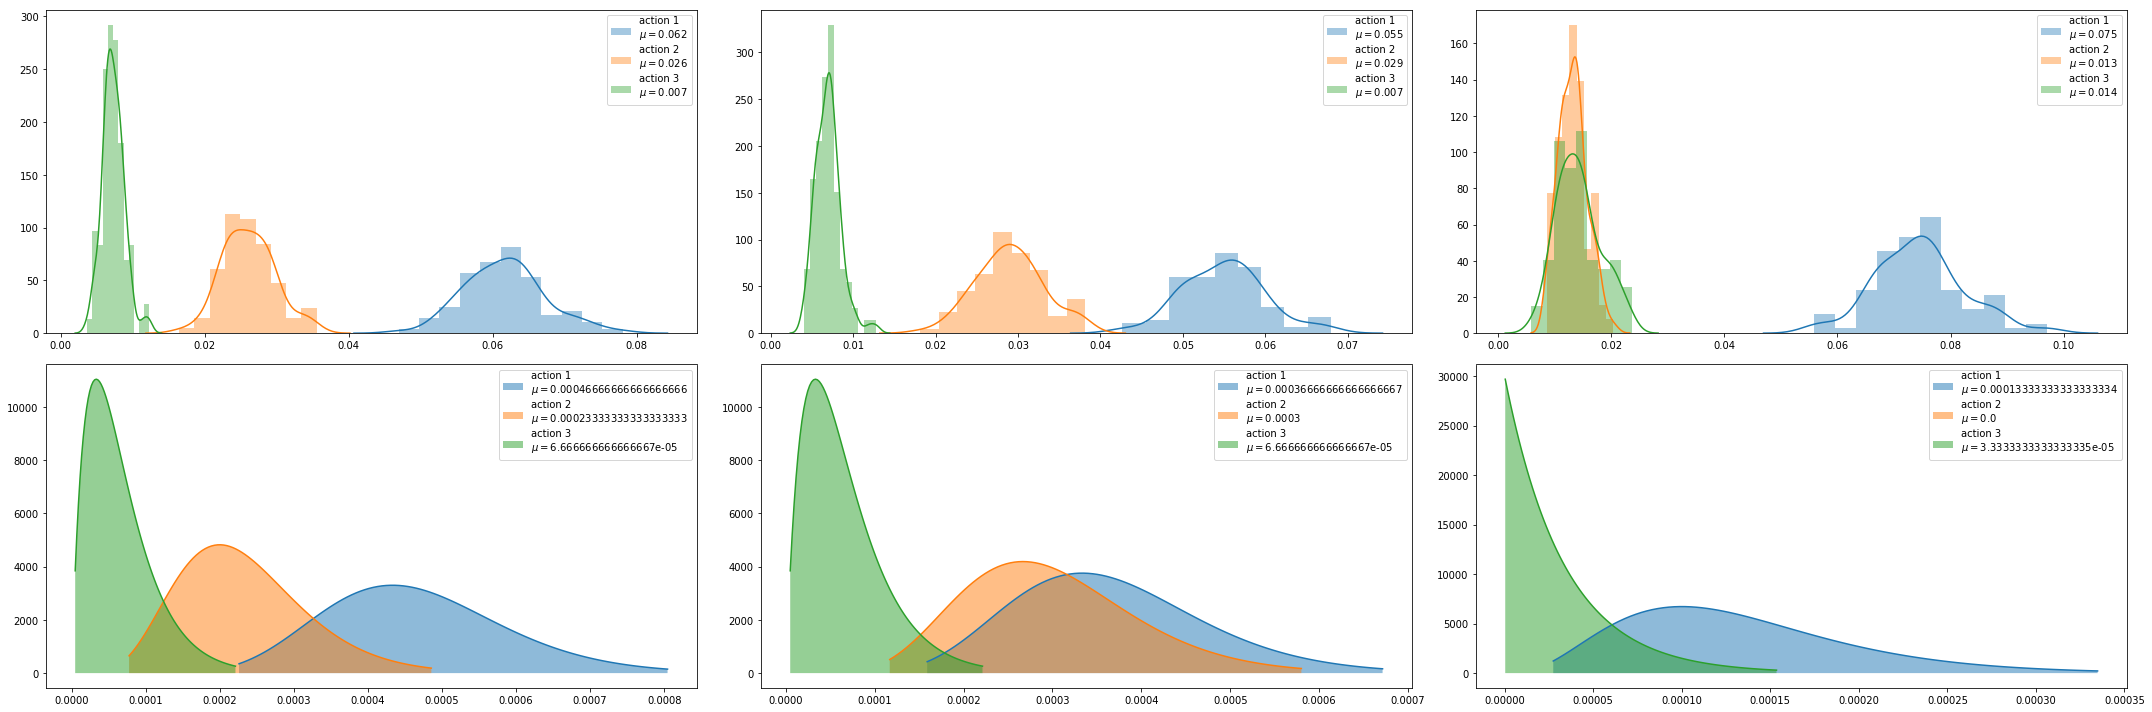

successes        failures                \
action_code              1   2  3        1      2      3   
O1 O2 C1  C2                                               
4  3  No  Yellow        17  12  1    29983  29988  29999   
1  2  Yes Yellow        17  10  5    29983  29990  29995   
   1  Yes Green          5   1  0    29995  29999  30000   

                                             bootstrap_probs_action  \
action_code                                                       1   
O1 O2 C1  C2                                                          
4  3  No  Yellow  [0.053673374785618615, 0.05262887613087651, 0....   
1  2  Yes Yellow  [0.05771826879955256, 0.05220108346024702, 0.0...   
   1  Yes Green   [0.058838631479139196, 0.050628612438420706, 0...   

                                                                     \
action_code                                                       2   
O1 O2 C1  C2                                                          
4  3  No  Yellow  [0.03575249709718348, 0.040386855847549155, 0....   
1  2  Yes Yellow  [0.02697643030731206, 0.02647735118361037, 0.0...   
   1  Yes Green   [0.020067861362467375, 0.016322239119280248, 0...   

                                                                     
action_code                                                       3  
O1 O2 C1  C2                                                         
4  3  No  Yellow  [0.002731919762799131, 0.0069632599711180135, ...  
1  2  Yes Yellow  [0.01393850369584321, 0.0130439315934844, 0.01...  
   1  Yes Green   [0.024035266818880796, 0.012467742991602101, 0...

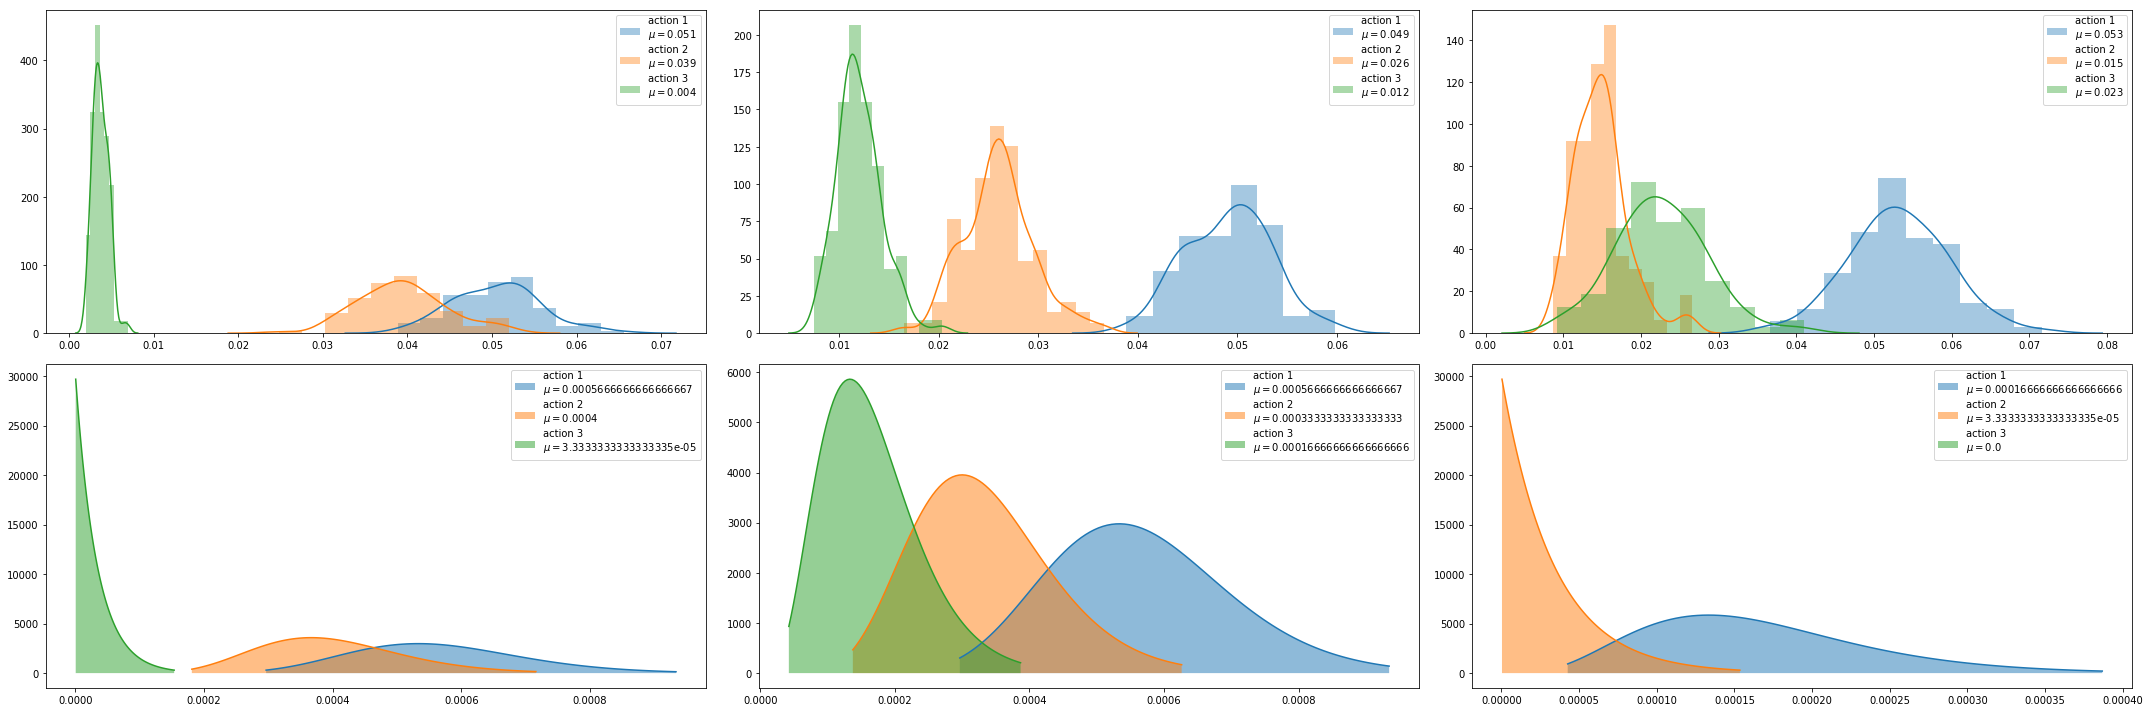

In [18]:
plot_contexts_probabilities(comparison_frame,[0,10,45])

As we can see most of the times the hierarchy is respected.

## Bayesian logistic model

We train a Bayesian logistic model using pymc3

In [19]:
from contextual_mab.predictive_models.bayesian_logistic import BayesianLogisticRegression

In [21]:
action_id=1

subset = synthetic_data[synthetic_data['action_code']==action_id]
subset = pd.get_dummies(subset.drop(columns=['action_code']),drop_first=True)
predictors = subset.drop(columns=['reward']).columns

X = subset.drop(columns=['reward']).values
y = subset['reward'].values

In [22]:
n_samples = 500
n_chains = 2
bayesian_logistic_model = BayesianLogisticRegression(n_samples,n_chains,predictors.tolist())

In [23]:
bayesian_logistic_model.fit(X,y)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [C3_C, C3_B, C2_Yellow, C1_Yes, O2, O1, X3, X2, X1, Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [01:04<00:00, 77.74draws/s]


In [24]:
bayesian_logistic_predictions = bayesian_logistic_model.predict(X)

### Posterior distributions for model vector

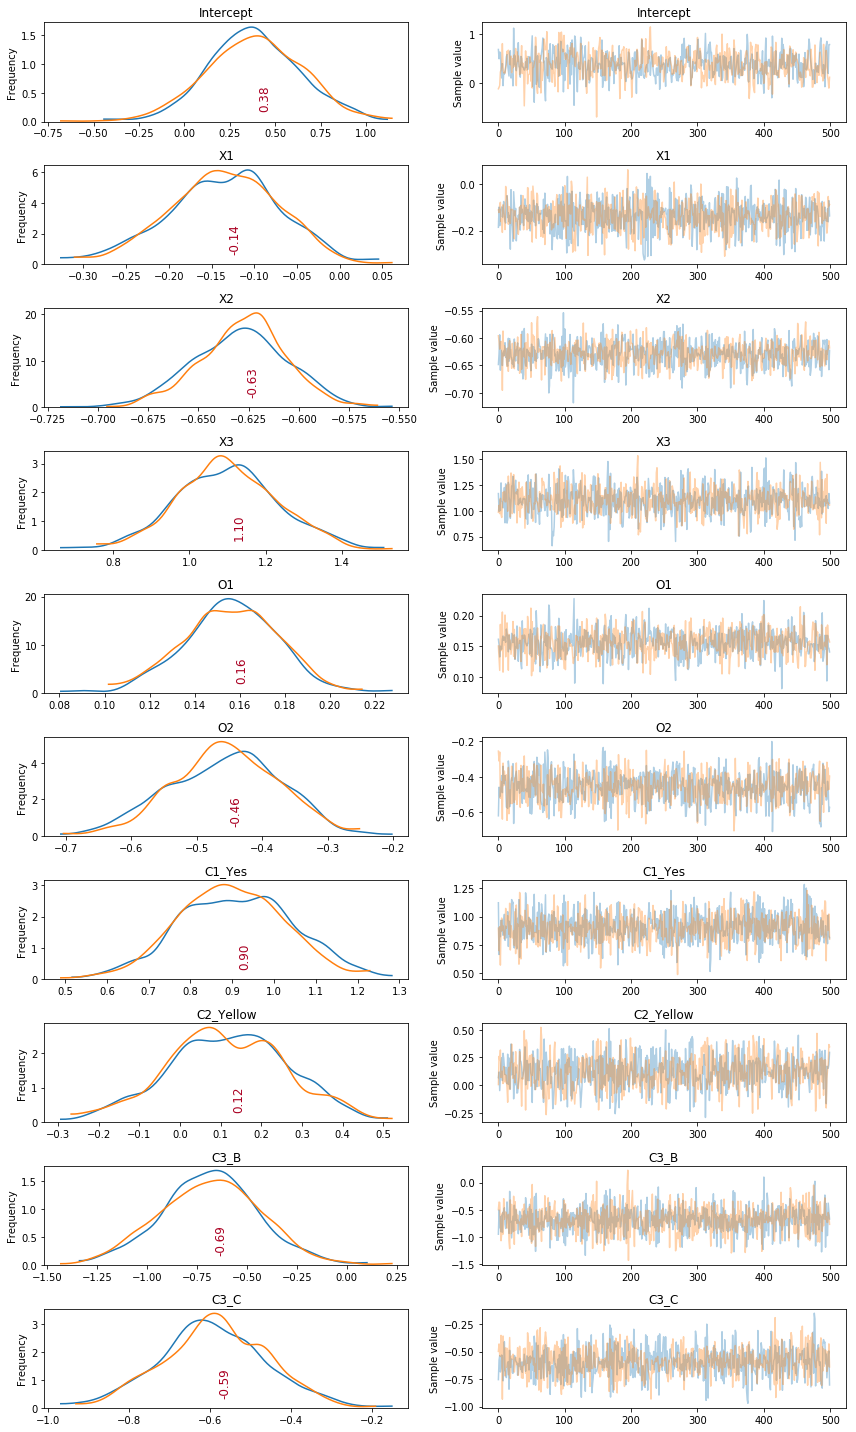

In [25]:
bayesian_logistic_model.plot_traces()

### Comparison with bootstrap oracle

We first compare the predictive distributions produced by the logistic oracle and the bayesian model on few contexts

In [26]:
logistic_params = {'solver':'lbfgs',
                   'random_state':0}

logistic_oracle = BootstrapOracle(n_samples*n_chains,LogisticRegression,logistic_params)

logistic_oracle.fit(X,y)
logistic_oracle_predictions = logistic_oracle.predict(X)

100%|██████████| 1000/1000 [00:42<00:00, 22.47it/s]
1000it [00:00, 2972.45it/s]


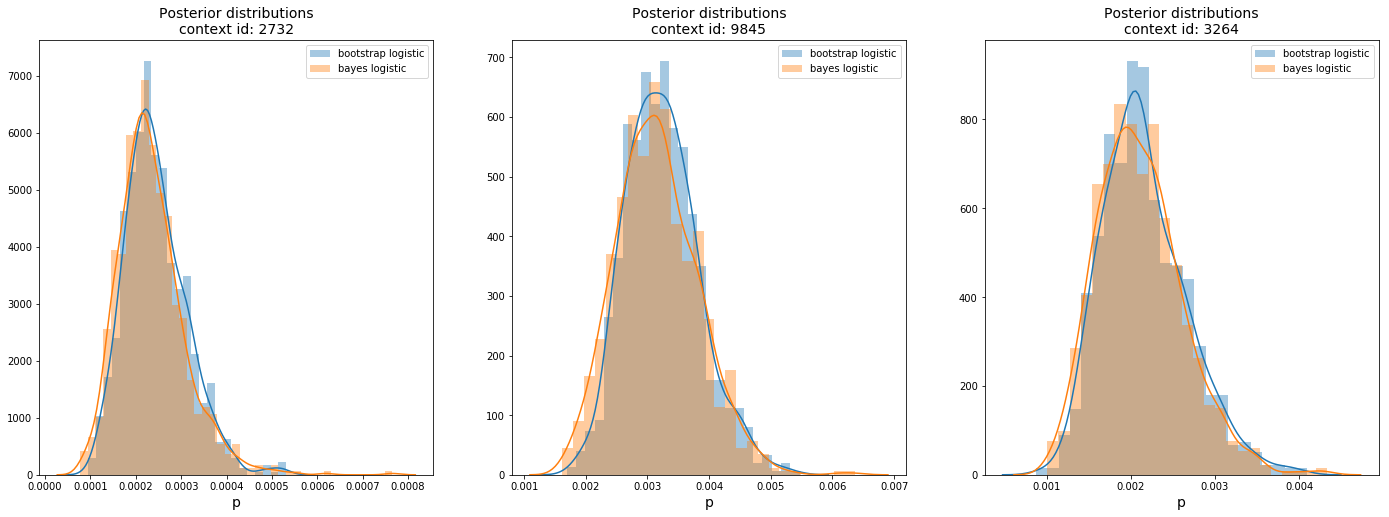

In [27]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,8))

np.random.seed(0)
context_idx = np.random.choice(range(X.shape[0]),3)
for idx,ax in zip(context_idx,[ax1,ax2,ax3]):
    sns.distplot(logistic_oracle_predictions[idx,:],label='bootstrap logistic',ax=ax)
    sns.distplot(bayesian_logistic_predictions[idx,:],label='bayes logistic',ax=ax)
    ax.set_title('Posterior distributions\ncontext id: {}'.format(idx),fontsize=14)
    ax.set_xlabel('p',fontsize=14)
    ax.legend()
plt.show()

as we can see, the two predictive distributions match quite well. We also inspect the overall reward predicted by these two models for the chosen action

In [28]:
logistic_oracle_target = (logistic_oracle_predictions >=.5)
logistic_bayesian_target = (bayesian_logistic_predictions >=.5)

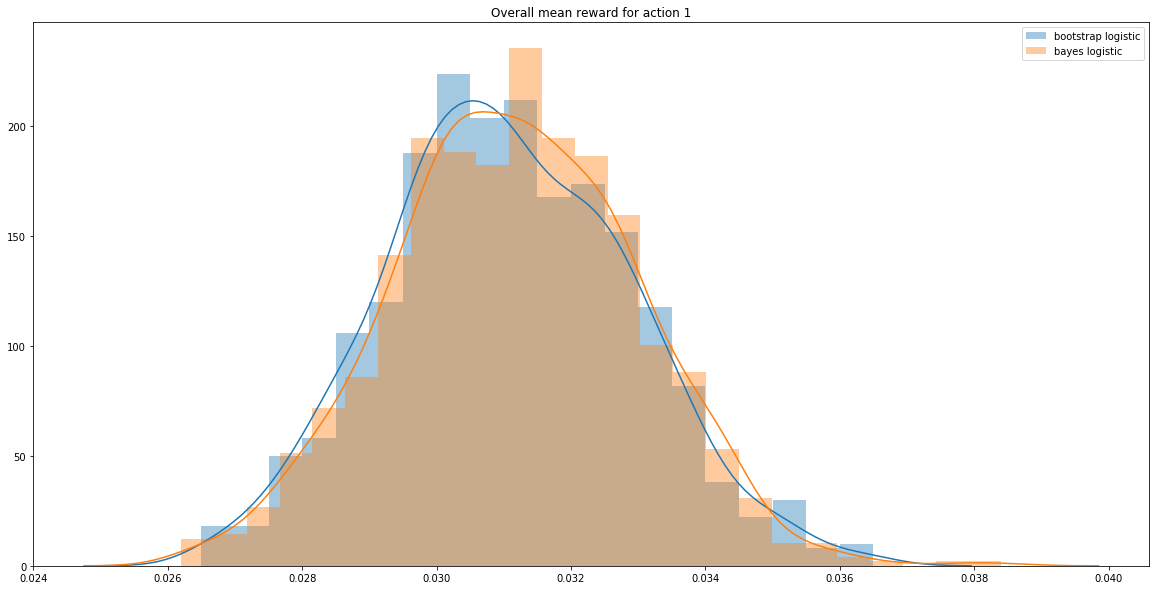

In [29]:
plt.figure(figsize=(20,10))

sns.distplot(logistic_oracle_target.mean(axis=0),label='bootstrap logistic')
sns.distplot(logistic_bayesian_target.mean(axis=0),label='bayes logistic')
plt.legend()
plt.title('Overall mean reward for action {}'.format(action_id))

plt.show()

Also in this case, the two models align quite well. We can notice that the overall predicted reward peaks around 0.031, and not around 0.05. This is caused by a combination of factors, namely
1. The size of the error term (we gave it a quite large standard deviartion (5)) used to generate synthetic data
2. The (non-hortodox) way we create non zero values of reward based on quantile values

By reducing the noise size, or increasing the class imbalance assigned to the global reward, this abherration should disappear.

### Model assessment

We finally perform the same sanity check as the one done for the boostrap oracles

In [30]:
action_probabilities = []
predictors = check_data.drop(columns=['reward','action_code']).columns
for action_id in pd.unique(check_data['action_code']):
    subset = check_data[check_data['action_code']==action_id]
    data = pd.get_dummies(subset[predictors],drop_first=True)
    data_cols = data.columns.tolist()
    X = data.values
    y = subset['reward'].values
    
    bayesian_logistic = BayesianLogisticRegression(n_samples,n_chains,data_cols)
    bayesian_logistic.fit(X,y)
    unique_contexts = subset.drop_duplicates(subset=predictors)[predictors]
    X_unique = pd.get_dummies(unique_contexts,drop_first=True).values
    logistic_bayesian_predictions = bayesian_logistic.predict(X_unique)
    unique_contexts['action_code'] = action_id
    unique_contexts['bootstrap_probs_action'.format(action_id)] = [logistic_bayesian_predictions[idx,:] for idx in range(len(logistic_bayesian_predictions))]
    action_probabilities.append(unique_contexts)
    
action_probabilities=pd.concat(action_probabilities)
action_probabilities = action_probabilities.set_index(keys=predictors.tolist()+['action_code'])
action_probabilities = action_probabilities.unstack('action_code')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [C2_Yellow, C1_Yes, O2, O1, Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:56<00:00, 89.07draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [C2_Yellow, C1_Yes, O2, O1, Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:59<00:00, 83.59draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [C2_Yellow, C1_Yes, O2, O1, Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:55<00:00, 47.58draws/s]


In [31]:
action_probabilities.head()

bootstrap_probs_action  \
action_code                                                       1   
O1 O2 C1  C2                                                          
1  1  No  Green   [0.04054594193030734, 0.03892205851149296, 0.0...   
          Yellow  [0.03680390612062896, 0.04354199680931517, 0.0...   
      Yes Green   [0.05232326780791333, 0.0503015304929515, 0.05...   
          Yellow  [0.04754815407532385, 0.05619320529617414, 0.0...   
   2  No  Green   [0.039799705266467575, 0.03901355364326324, 0....   

                                                                     \
action_code                                                       2   
O1 O2 C1  C2                                                          
1  1  No  Green   [0.019920418766537776, 0.019531789037183223, 0...   
          Yellow  [0.029567713586120987, 0.030325063735612286, 0...   
      Yes Green   [0.014508337333557636, 0.01389462147818951, 0....   
          Yellow  [0.021592350082881503, 0.021641553659257056, 0...   
   2  No  Green   [0.024948211464431477, 0.025095206269320085, 0...   

                                                                     
action_code                                                       3  
O1 O2 C1  C2                                                         
1  1  No  Green   [0.009883258718032173, 0.009742394775693795, 0...  
          Yellow  [0.010560459390313602, 0.009712036576198003, 0...  
      Yes Green   [0.022068530302406693, 0.018274614539972204, 0...  
          Yellow  [0.023560797433393836, 0.01821815829263334, 0....  
   2  No  Green   [0.005115070372810928, 0.0047662577223932245, ...

In [32]:
subset = check_data
predictors = subset.drop(columns = ['reward']).columns.tolist()
grouped = subset.groupby(by=predictors)[['reward']].sum()
grouped['successes'] = grouped['reward']
grouped['failures'] = len(subset)-grouped['successes']
grouped.drop(columns='reward',inplace=True)
grouped=grouped.unstack('action_code')
grouped.head()

successes        failures              
action_code              1   2  3        1      2      3
O1 O2 C1  C2                                            
1  1  No  Green          3   2  1    29997  29998  29999
          Yellow        17  10  5    29983  29990  29995
      Yes Green          5   1  0    29995  29999  30000
          Yellow        14   6  4    29986  29994  29996
   2  No  Green          2   6  1    29998  29994  29999

In [33]:
comparison_frame = pd.merge(grouped,action_probabilities,left_index=True,right_index=True)
comparison_frame.head()

successes        failures                \
action_code              1   2  3        1      2      3   
O1 O2 C1  C2                                               
1  1  No  Green          3   2  1    29997  29998  29999   
          Yellow        17  10  5    29983  29990  29995   
      Yes Green          5   1  0    29995  29999  30000   
          Yellow        14   6  4    29986  29994  29996   
   2  No  Green          2   6  1    29998  29994  29999   

                                             bootstrap_probs_action  \
action_code                                                       1   
O1 O2 C1  C2                                                          
1  1  No  Green   [0.04054594193030734, 0.03892205851149296, 0.0...   
          Yellow  [0.03680390612062896, 0.04354199680931517, 0.0...   
      Yes Green   [0.05232326780791333, 0.0503015304929515, 0.05...   
          Yellow  [0.04754815407532385, 0.05619320529617414, 0.0...   
   2  No  Green   [0.039799705266467575, 0.03901355364326324, 0....   

                                                                     \
action_code                                                       2   
O1 O2 C1  C2                                                          
1  1  No  Green   [0.019920418766537776, 0.019531789037183223, 0...   
          Yellow  [0.029567713586120987, 0.030325063735612286, 0...   
      Yes Green   [0.014508337333557636, 0.01389462147818951, 0....   
          Yellow  [0.021592350082881503, 0.021641553659257056, 0...   
   2  No  Green   [0.024948211464431477, 0.025095206269320085, 0...   

                                                                     
action_code                                                       3  
O1 O2 C1  C2                                                         
1  1  No  Green   [0.009883258718032173, 0.009742394775693795, 0...  
          Yellow  [0.010560459390313602, 0.009712036576198003, 0...  
      Yes Green   [0.022068530302406693, 0.018274614539972204, 0...  
          Yellow  [0.023560797433393836, 0.01821815829263334, 0....  
   2  No  Green   [0.005115070372810928, 0.0047662577223932245, ...

successes        failures                \
action_code              1   2  3        1      2      3   
O1 O2 C1  C2                                               
3  2  No  Yellow        25  20  3    29975  29980  29997   
1  2  No  Green          2   6  1    29998  29994  29999   
3  1  Yes Green          6   1  3    29994  29999  29997   

                                             bootstrap_probs_action  \
action_code                                                       1   
O1 O2 C1  C2                                                          
3  2  No  Yellow  [0.04634211815207083, 0.04606806410992425, 0.0...   
1  2  No  Green   [0.039799705266467575, 0.03901355364326324, 0....   
3  1  Yes Green   [0.06680605391572587, 0.053075014140033155, 0....   

                                                                     \
action_code                                                       2   
O1 O2 C1  C2                                                          
3  2  No  Yellow  [0.03503144673186361, 0.03633072317959005, 0.0...   
1  2  No  Green   [0.024948211464431477, 0.025095206269320085, 0...   
3  1  Yes Green   [0.01374272033099876, 0.012974840762585711, 0....   

                                                                     
action_code                                                       3  
O1 O2 C1  C2                                                         
3  2  No  Yellow  [0.005542181845388226, 0.006148811303180897, 0...  
1  2  No  Green   [0.005115070372810928, 0.0047662577223932245, ...  
3  1  Yes Green   [0.022365437200767065, 0.023555475786337664, 0...

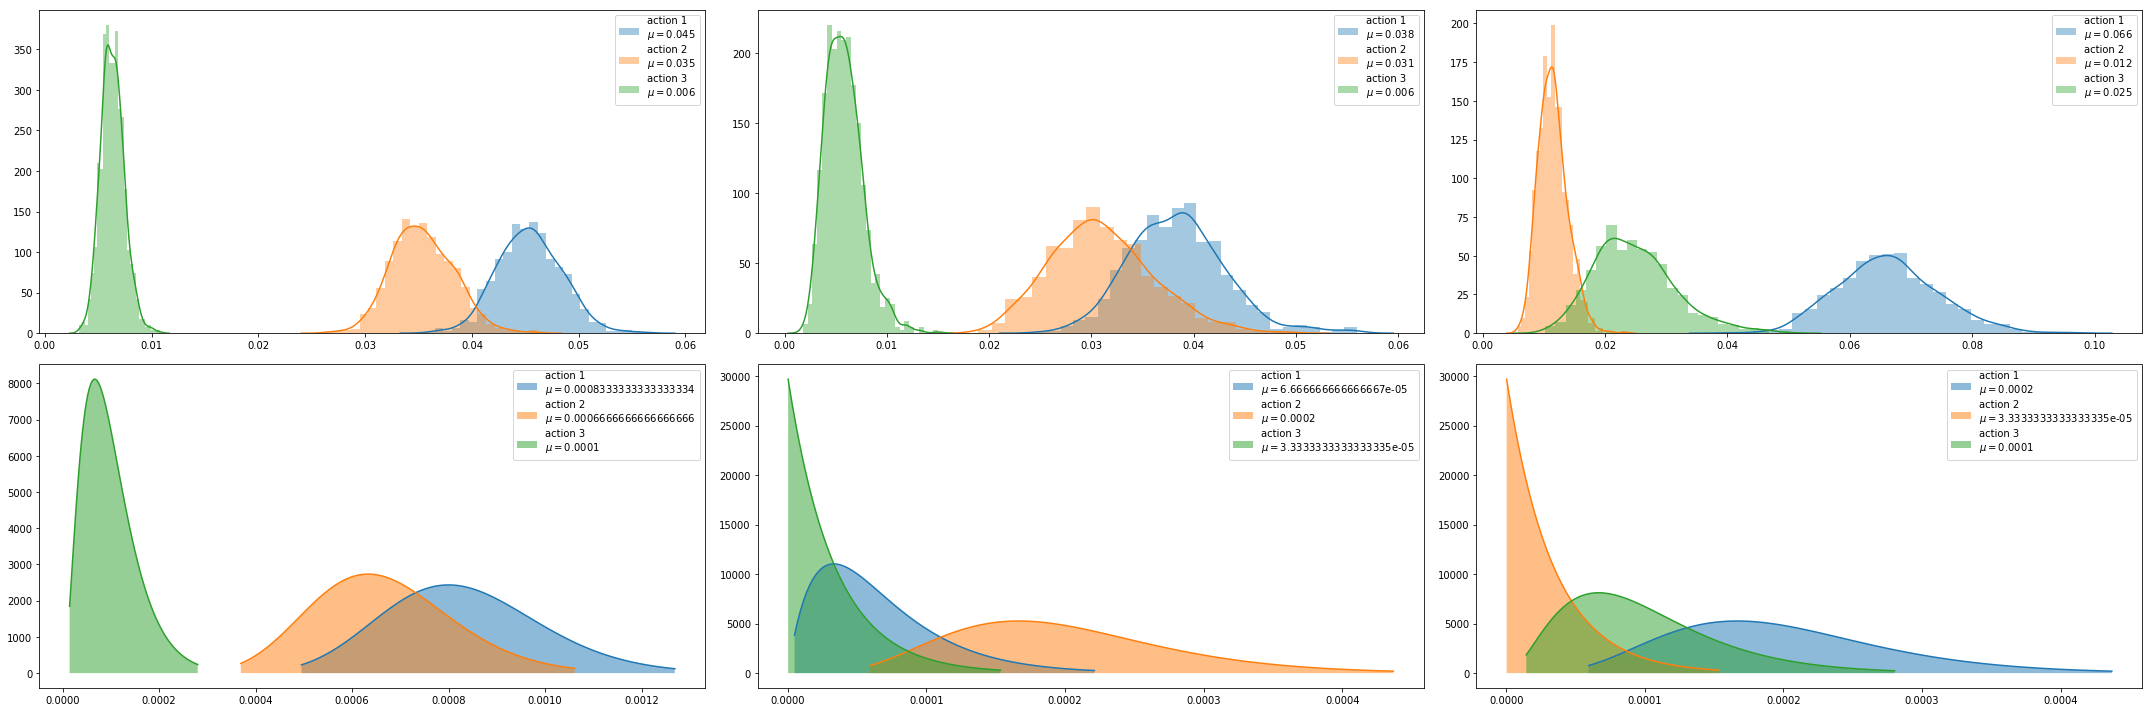

successes       failures                \
action_code              1  2  3        1      2      3   
O1 O2 C1  C2                                              
3  3  Yes Yellow        14  7  2    29986  29993  29998   
2  3  Yes Yellow        11  9  2    29989  29991  29998   
4  2  Yes Green          4  0  1    29996  30000  29999   

                                             bootstrap_probs_action  \
action_code                                                       1   
O1 O2 C1  C2                                                          
3  3  Yes Yellow  [0.05862110214947828, 0.05954430634835242, 0.0...   
2  3  Yes Yellow  [0.05185149161087381, 0.05797927963774554, 0.0...   
4  2  Yes Green   [0.07403513277960844, 0.05464138822284365, 0.0...   

                                                                     \
action_code                                                       2   
O1 O2 C1  C2                                                          
3  3  Yes Yellow  [0.0320408565465898, 0.033309522835649245, 0.0...   
2  3  Yes Yellow  [0.032904665549796625, 0.03444550455480594, 0....   
4  2  Yes Green   [0.016779040545043006, 0.016141786401959096, 0...   

                                                                     
action_code                                                       3  
O1 O2 C1  C2                                                         
3  3  Yes Yellow  [0.006447649039560093, 0.005666014051907066, 0...  
2  3  Yes Yellow  [0.006404017842997447, 0.004980625064386149, 0...  
4  2  Yes Green   [0.011724966151229204, 0.01319182822612713, 0....

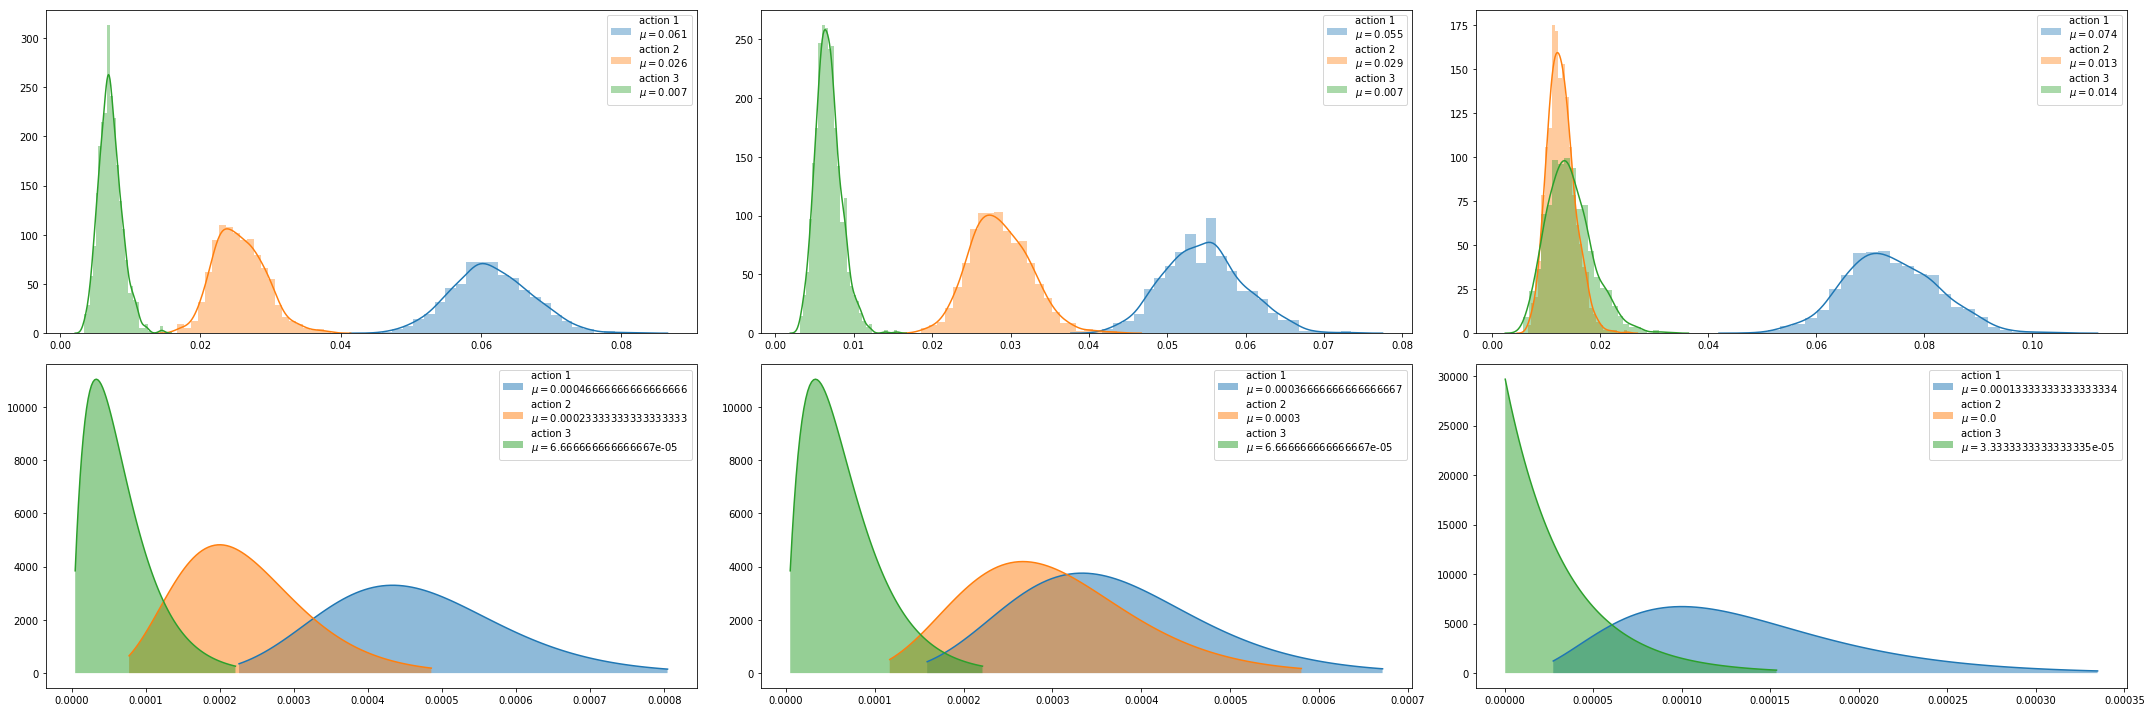

successes        failures                \
action_code              1   2  3        1      2      3   
O1 O2 C1  C2                                               
4  3  No  Yellow        17  12  1    29983  29988  29999   
1  2  Yes Yellow        17  10  5    29983  29990  29995   
   1  Yes Green          5   1  0    29995  29999  30000   

                                             bootstrap_probs_action  \
action_code                                                       1   
O1 O2 C1  C2                                                          
4  3  No  Yellow  [0.05147895162157148, 0.04743800553356287, 0.0...   
1  2  Yes Yellow  [0.04667931362469236, 0.05632292087417268, 0.0...   
   1  Yes Green   [0.05232326780791333, 0.0503015304929515, 0.05...   

                                                                     \
action_code                                                       2   
O1 O2 C1  C2                                                          
4  3  No  Yellow  [0.04256829225180273, 0.04493890150428776, 0.0...   
1  2  Yes Yellow  [0.02703048977995247, 0.02778888213327063, 0.0...   
   1  Yes Green   [0.014508337333557636, 0.01389462147818951, 0....   

                                                                     
action_code                                                       3  
O1 O2 C1  C2                                                         
4  3  No  Yellow  [0.002881867088419042, 0.0034167353250948254, ...  
1  2  Yes Yellow  [0.012275679073512829, 0.00895197925350582, 0....  
   1  Yes Green   [0.022068530302406693, 0.018274614539972204, 0...

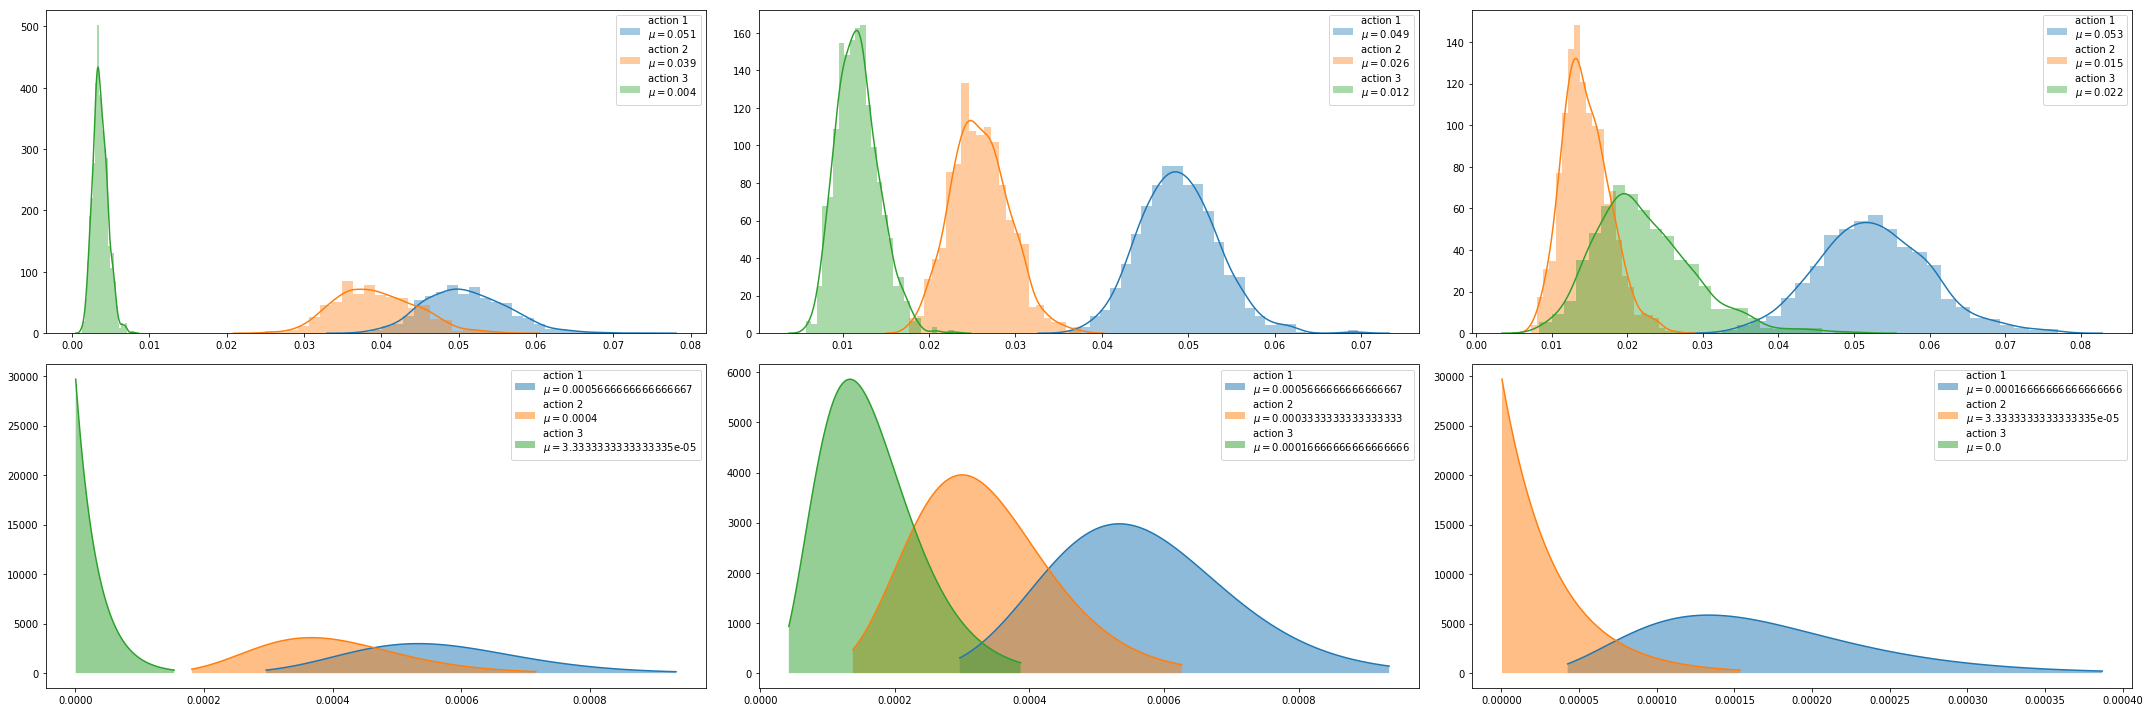

In [34]:
plot_contexts_probabilities(comparison_frame,[0,10,45])